In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass 
import statsmodels.api as sm

In [2]:
sns.set_style("white")

In [3]:
price = np.array([7,20,13,59,40,51,37])
review_score = np.array([7,6,8,1,3,2,3])

### **1. Mean**

In [4]:
type(price)

numpy.ndarray

In [5]:
price.mean()

32.42857142857143

In [6]:
review_score.mean()

4.285714285714286

### **2. Variance**

In [7]:
ddof = 1

In [8]:
price.var(ddof=ddof)

384.61904761904754

In [9]:
review_score.var(ddof=ddof)

7.238095238095238

### **3. Standard Deviation**

In [10]:
price.std(ddof=ddof)

19.611706902231827

In [11]:
np.sqrt(price.var(ddof=ddof))

19.611706902231827

In [12]:
review_score.std(ddof=ddof)

2.690370836538197

In [13]:
np.sqrt(review_score.var(ddof=ddof))

2.690370836538197

### **4. Covariance**

In [14]:
np.cov(price, review_score, ddof=ddof)

array([[384.61904762, -51.30952381],
       [-51.30952381,   7.23809524]])

In [15]:
cov = np.cov(price, review_score, ddof=ddof)

In [16]:
cov[0,1]

-51.3095238095238

### **5. Correlation (Pearson)**

In [17]:
cov[0,1] / np.sqrt(price.var(ddof=ddof) * review_score.var(ddof=ddof))

-0.9724570819188173

In [18]:
np.corrcoef(price, review_score)

array([[ 1.        , -0.97245708],
       [-0.97245708,  1.        ]])

In [19]:
#use statsmodels
df = pd.DataFrame({"y": review_score, "x": price})

In [20]:
df

,y,x
0,7,7
1,6,20
2,8,13
3,1,59
4,3,40
5,2,51
6,3,37


In [21]:
df = sm.add_constant(df)

In [22]:
df

,const,y,x
0,1.0,7,7
1,1.0,6,20
2,1.0,8,13
3,1.0,1,59
4,1.0,3,40
5,1.0,2,51
6,1.0,3,37


In [23]:
#way 1
model = sm.OLS(df["y"], 
       df[["const", "x"]])
results = model.fit()

In [24]:
# way 2
results2 = sm.OLS(df["y"], 
                  df[["const", "x"]]).fit()

In [25]:
#way 3
y = df["y"]
X = df[["const", "x"]]
lin_reg = sm.OLS(y, X).fit()

In [26]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [27]:
results.summary()

/Users/emilyhorton/opt/anaconda3/envs/matrix/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     87.03
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           0.000238
Time:                        14:01:43   Log-Likelihood:                -6.1262
No. Observations:                   7   AIC:                             16.25
Df Residuals:                       5   BIC:                             16.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6118      0.531     16.204      0.000       7.246       9.978
x             -0.1334      0.014     -9.329      0.000      -0.170      -0.097
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.559
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.457
Skew:                           0.582   Prob(JB):                        0.796
Kurtosis:                       2.539   Cond. No.                         76.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For increase in price by 1 EUR, our review_score decreases by 0.1334

y = 8.6118 - 0.1334x

In [33]:
df = df.assign(y_hat=lin_reg.predict(df[["const", "x"]]))

In [34]:
df

,const,y,x,y_hat
0,1.0,7,7,7.677974
1,1.0,6,20,5.943729
2,1.0,8,13,6.877554
3,1.0,1,59,0.740993
4,1.0,3,40,3.275659
5,1.0,2,51,1.808221
6,1.0,3,37,3.675870


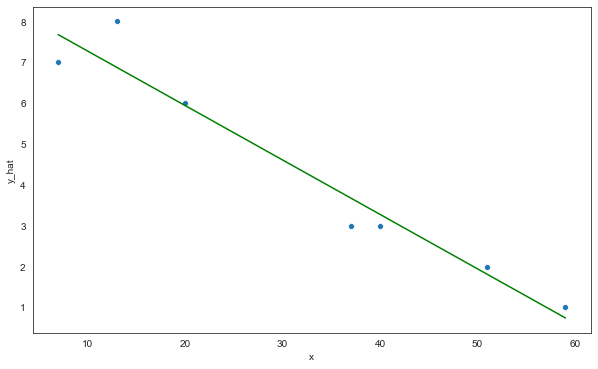

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df,
                x="x",
                y="y",
                ax=ax);

sns.lineplot(data=df,
             x="x",
             y="y_hat",
             color="green",
             ax=ax);

# Olist Linear Regression

In [36]:
conn = pymysql.connect(host='localhost',
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


In [41]:
query = """
SELECT 
    o.order_id, 
    dor.review_score, 
    DATEDIFF(DATE(o.order_estimated_delivery_date), DATE(o.order_purchase_timestamp)) AS estimated_delivery_days, 
    DATEDIFF(DATE(o.order_delivered_customer_date), DATE(o.order_purchase_timestamp)) AS actual_delivery_days, 
    DATEDIFF(DATE(o.order_estimated_delivery_date), DATE(o.order_purchase_timestamp)) - 
    DATEDIFF(DATE(o.order_delivered_customer_date), DATE(o.order_purchase_timestamp))  AS delivery_diff,
    oid.total_price, 
    oid.shipping_costs, 
    oid.order_size, 
    oid.has_product_photo, 
    oid.has_product_decription AS has_product_description
FROM orders o
    JOIN temp_dedup_order_reviews dor
    ON o.order_id = dor.order_id
    JOIN temp_order_item_details oid
    ON o.order_id = oid.order_id
WHERE o.order_status = 'delivered';
"""

In [42]:
review_score = pd.read_sql(query, conn)

In [43]:
review_score

,order_id,review_score,estimated_delivery_days,actual_delivery_days,delivery_diff,total_price,shipping_costs,order_size,has_product_photo,has_product_description
0,e481f51cbdc54678b7cc49136f2d6af7,4,16,8.0,8.0,29.990000,8.720000,1,1.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,4,20,14.0,6.0,118.699997,22.760000,1,1.0,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,5,27,9.0,18.0,159.899994,19.219999,1,1.0,1.0
3,949d5b44dbf5de918fe9c16f97b45f8a,5,27,14.0,13.0,45.000000,27.200001,1,1.0,1.0
4,ad21c59c0840e6cb83a9ceb5573f8159,5,13,3.0,10.0,19.900000,8.720000,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
96473,9c5dedf39a927c1b2549525ed64a053c,5,19,8.0,11.0,72.000000,13.080000,1,1.0,1.0
96474,63943bddc261676b46f01ca7ac2f7bd8,4,24,22.0,2.0,174.899994,20.100000,1,1.0,1.0
96475,83c1379a015df1e13d02aae0204711ab,5,31,25.0,6.0,205.990005,65.019997,1,1.0,1.0
96476,11c177c8e97725db2631073c19f07b62,2,38,18.0,20.0,359.980011,81.180000,2,2.0,2.0


In [44]:
review_score = sm.add_constant(review_score)

In [45]:
review_score = review_score.replace([np.inf, -np.inf], np.nan).dropna()

## 1st Model: Do the review scores correlated with delievery_diff?

In [48]:
rev_y = review_score["review_score"]
rev_X = review_score[["const", "delivery_diff"]]

rev_lr = sm.OLS(rev_y, rev_X).fit()

In [49]:
rev_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7539.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:04:58   Log-Likelihood:            -1.5818e+05
No. Observations:               96470   AIC:                         3.164e+05
Df Residuals:                   96468   BIC:                         3.164e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.7413      0.006    609.340      0.000       3.729       3.753
delivery_diff     0.0342      0.000     86.826      0.000       0.033       0.035
==============================================================================
Omnibus:                    19324.149   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33261.356
Skew:                          -1.349   Prob(JB):                         0.00
Kurtosis:                       3.997   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For each additional delievery_diff day, our review_score increased by 0.0342. However, this model only explains 7.2% of the varaition in review score. In terms of an R squared, it is very weak. 

## 2nd model: review score as a function of multiple regressors
Add in shipping costs

In [50]:
rev_y2 = review_score["review_score"]
rev_X2 = review_score[["const", "delivery_diff", "shipping_costs"]]

rev_lr2 = sm.OLS(rev_y2, rev_X2).fit()

In [51]:
rev_lr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4386.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:11:11   Log-Likelihood:            -1.5761e+05
No. Observations:               96470   AIC:                         3.152e+05
Df Residuals:                   96467   BIC:                         3.153e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.8765      0.007    531.371      0.000       3.862       3.891
delivery_diff      0.0349      0.000     88.900      0.000       0.034       0.036
shipping_costs    -0.0063      0.000    -33.823      0.000      -0.007      -0.006
==============================================================================
Omnibus:                    18891.552   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32347.168
Skew:                          -1.312   Prob(JB):                         0.00
Kurtosis:                       4.076   Cond. No.                         60.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For every increase in shipping cost by one unit, the review score decreases by 0.0063 c.p. (ceteris paribus): holding all else constant. 

## 3rd Model

In [52]:
review_score.head()

,const,order_id,review_score,estimated_delivery_days,actual_delivery_days,delivery_diff,total_price,shipping_costs,order_size,has_product_photo,has_product_description
0,1.0,e481f51cbdc54678b7cc49136f2d6af7,4,16,8.0,8.0,29.990000,8.720000,1,1.0,1.0
1,1.0,53cdb2fc8bc7dce0b6741e2150273451,4,20,14.0,6.0,118.699997,22.760000,1,1.0,1.0
2,1.0,47770eb9100c2d0c44946d9cf07ec65d,5,27,9.0,18.0,159.899994,19.219999,1,1.0,1.0
3,1.0,949d5b44dbf5de918fe9c16f97b45f8a,5,27,14.0,13.0,45.000000,27.200001,1,1.0,1.0
4,1.0,ad21c59c0840e6cb83a9ceb5573f8159,5,13,3.0,10.0,19.900000,8.720000,1,1.0,1.0


- total_price/order size: -
- has_product_photo: +
- actual_delivery_days: -

In [53]:
review_score = review_score.assign(price_per_item=review_score["total_price"]/review_score["order_size"])

In [54]:
review_score.columns

Index(['const', 'order_id', 'review_score', 'estimated_delivery_days',
       'actual_delivery_days', 'delivery_diff', 'total_price',
       'shipping_costs', 'order_size', 'has_product_photo',
       'has_product_description', 'price_per_item'],
      dtype='object')

In [55]:
rev_y3 = review_score["review_score"]
rev_X3 = review_score[["const", "price_per_item", "has_product_photo", "actual_delivery_days"]]

rev_lr3 = sm.OLS(rev_y3, rev_X3).fit()

In [56]:
rev_lr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4688.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:26:24   Log-Likelihood:            -1.5524e+05
No. Observations:               96470   AIC:                         3.105e+05
Df Residuals:                   96466   BIC:                         3.105e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.0340      0.011    472.840      0.000       5.013       5.055
price_per_item        4.714e-05   2.06e-05      2.288      0.022    6.77e-06    8.75e-05
has_product_photo       -0.2873      0.007    -40.603      0.000      -0.301      -0.273
actual_delivery_days    -0.0457      0.000   -112.053      0.000      -0.047      -0.045
==============================================================================
Omnibus:                    18276.084   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31974.455
Skew:                          -1.232   Prob(JB):                         0.00
Kurtosis:                       4.371   Cond. No.                         710.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""